In [ ]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta']


##  Data reading

In [4]:
# run_dir = "/data/marian/cigar/runs/20251015_Xe_Kr_17deg_54.5V_Majority"
# filename = f"{run_dir}/Acq_dig2-192.168.0.254_20251015160926-16.bin"

# run         = '20251016_Xe_Kr_1.5bar_17deg_54.5V_Majority'
run         = 'Run7'
run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 5
nevents_per_wvf = 500

samples_per_waveform = 752

# event_header_bytes = 28
event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = None


In [5]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_dir)[:nfiles]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveforms shape: (500, 5, 752)
Waveform

In [ ]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes,
                                             sample_binning = sample_binning
                                             )  
        dataframes.append(df)

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020130311-31.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020151517-33.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020145740-33.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020150537-33.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020132434-31.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020125123-31.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020133436-31.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020150258-33.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020125450-31.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020145459-33.bin
/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run7/Acq_dig2-192.168.0.254_20251020134228-31.bin
/home/marian/CIGAR_AN

KeyboardInterrupt: 

In [ ]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

In [6]:
df = merged_df
df.head()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,event,event_time
0,8.000000e-09,1.763172,-370.237427,-555.541321,-407.312286,-545.031677,-347.459015,-605.131104,-404.270020,-561.339600,2012,38946492595
1,1.600000e-08,1.705032,-370.913269,-563.213684,-407.619507,-557.421570,-347.459015,-602.493713,-404.023956,-566.555359,2012,38946492595
2,2.400000e-08,1.802340,-371.159027,-569.965393,-407.988159,-567.971375,-347.765808,-599.120300,-403.777893,-569.439331,2012,38946492595
3,3.200000e-08,1.823148,-371.896332,-571.990906,-408.233948,-577.662476,-348.195312,-596.421570,-403.839417,-573.980164,2012,38946492595
4,4.000000e-08,1.832940,-371.712006,-570.272278,-407.742371,-587.414856,-348.870209,-592.557434,-403.777893,-578.030029,2012,38946492595


##  Data selection

In [7]:
# Filter for a specific event (change index as needed)
event_list  = df['event'].unique()
nevents     = len(event_list)
print(f'Unfiltered df nevents = {nevents}')

Unfiltered df nevents = 1500


In [8]:
# channels = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5']
channels = ['CH3', 'CH5', 'CH7', 'CH9']
# channels = ['CH2', 'CH3', 'CH4', 'CH5']

In [9]:
selected_event = 100
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event


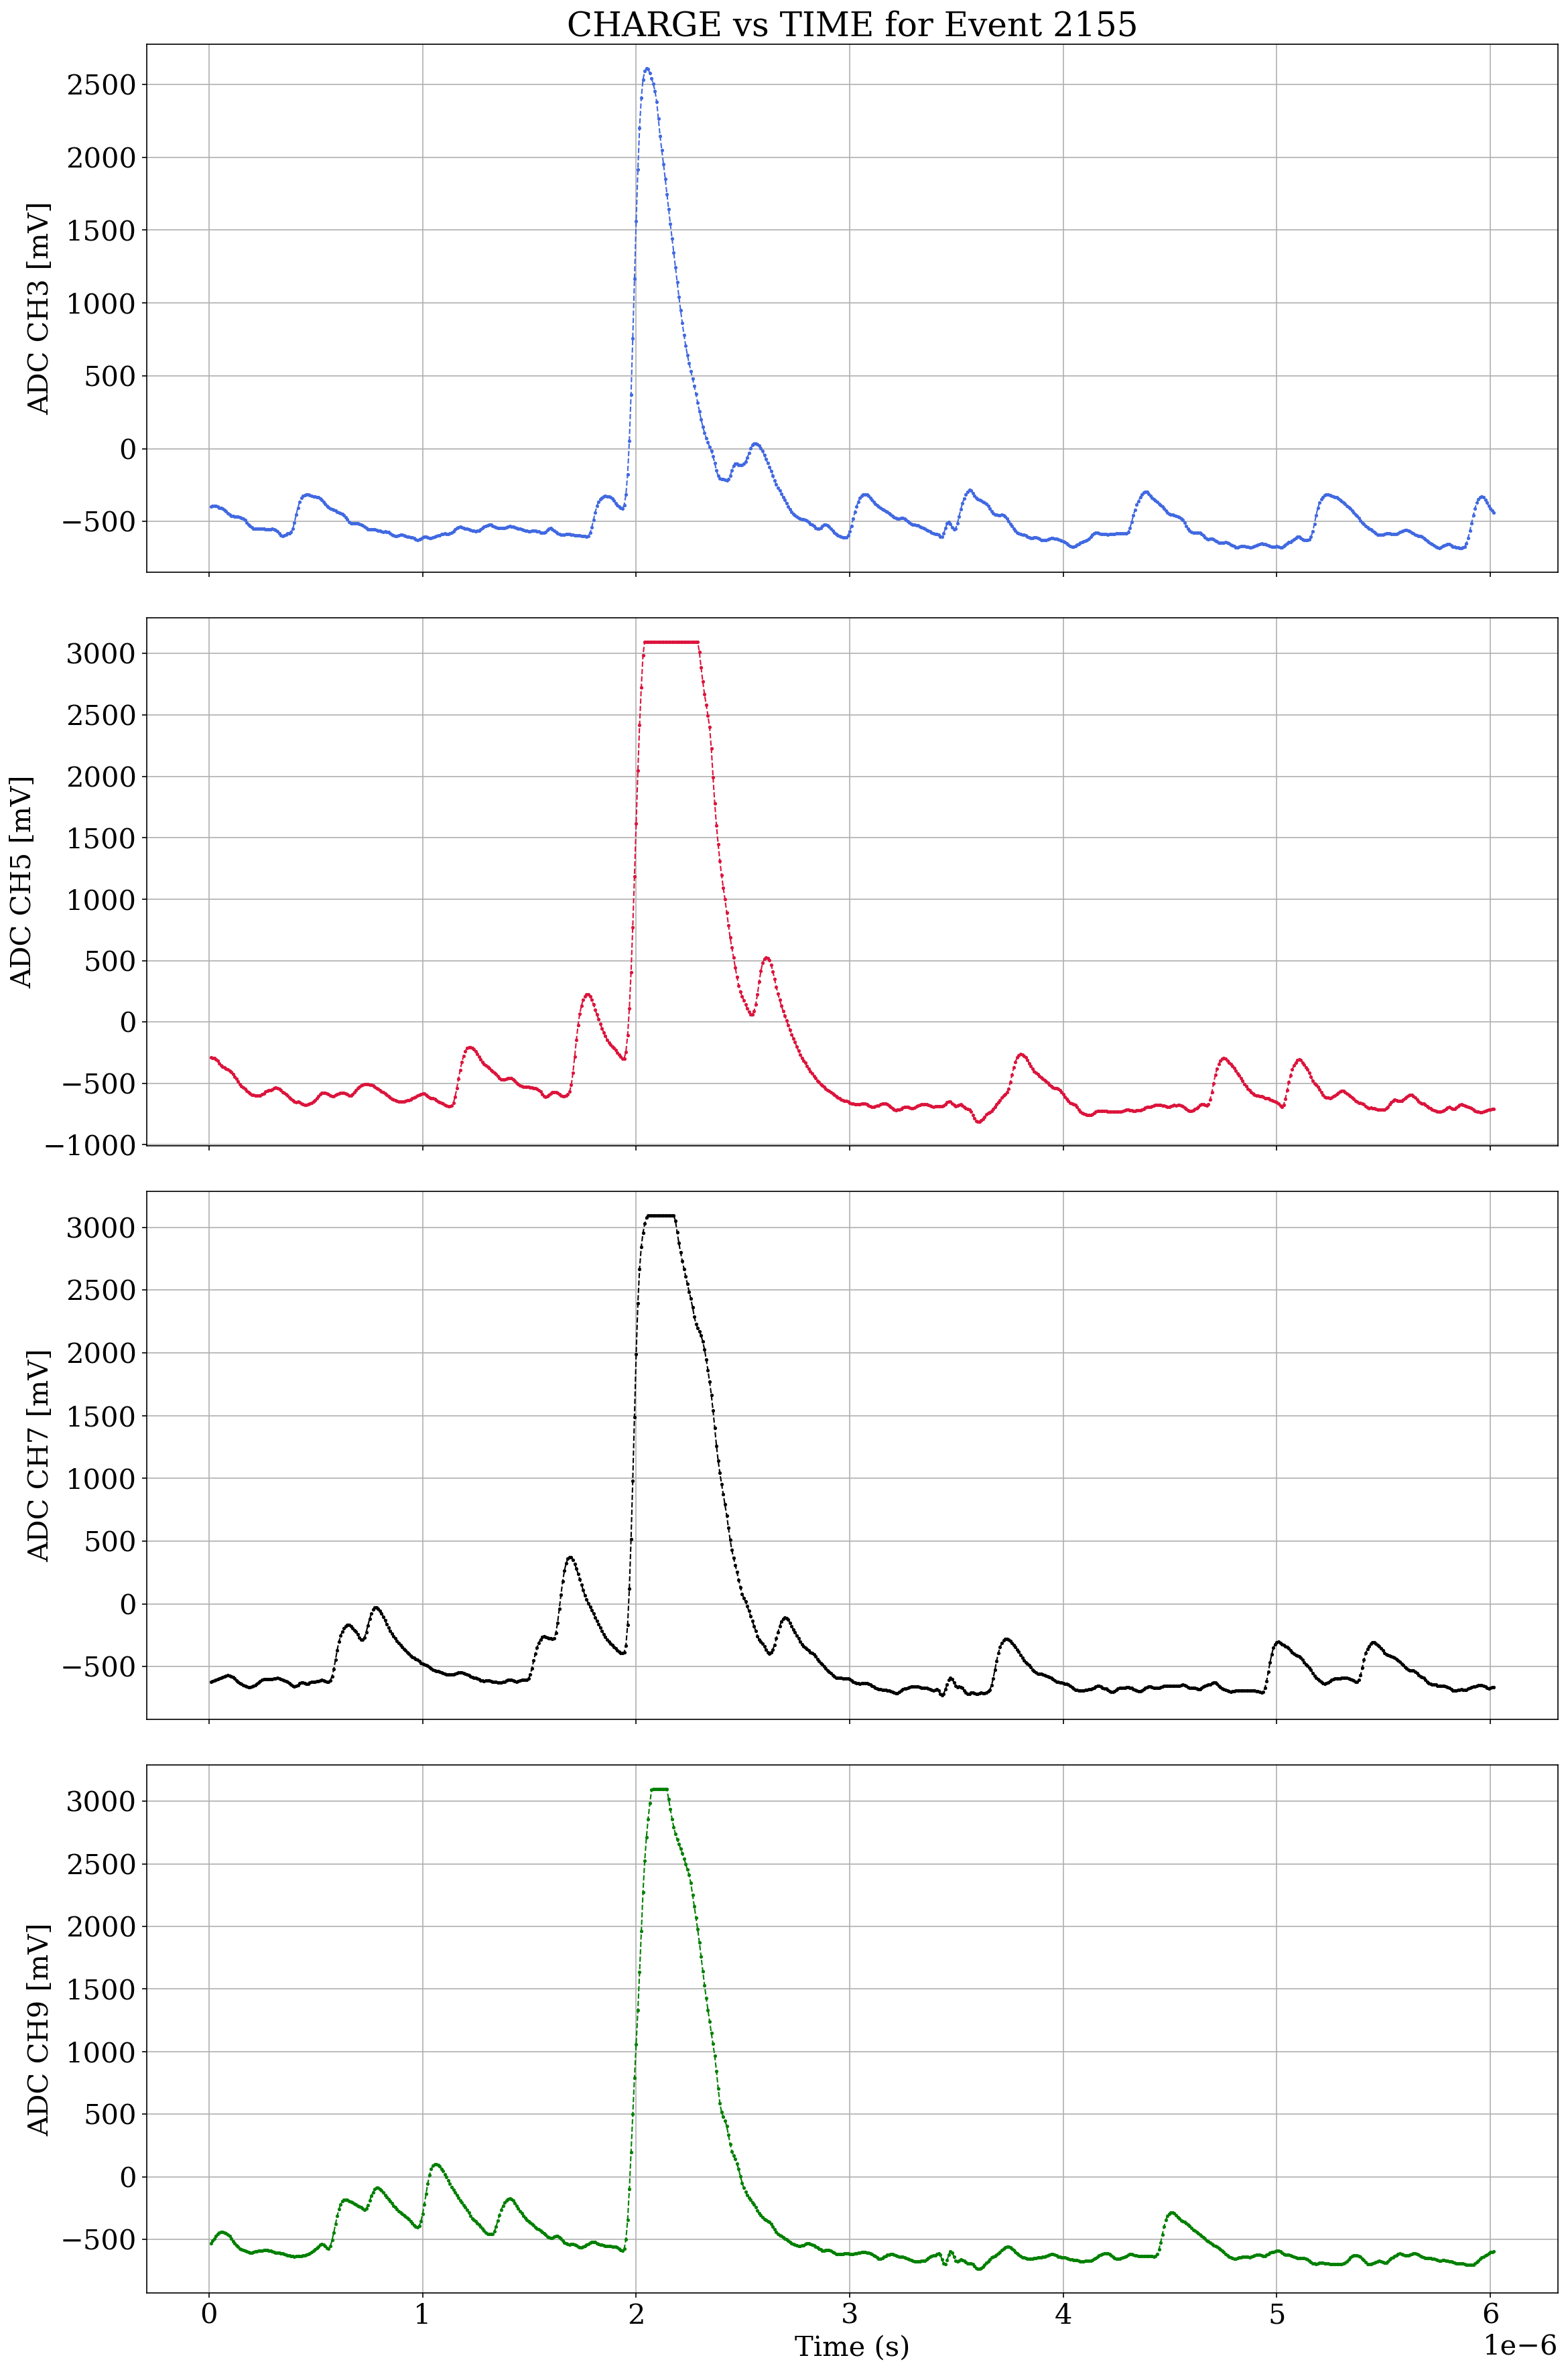

In [11]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]}')

else:
    ax.set_title(f'CHARGE vs TIME for Event {event_list[selected_event]}')

# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    ax.plot(df_event['TIME'].values, df_event[f'{channels[i]}'].values, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{channels[i]}')
    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')
# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Data filtering

In [12]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, threshold=1000):
    peak_count = 0
    for ch in channels:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts = df.groupby("event").apply(count_high_peaks)

# keep only events with <= 5 peaks above 2000
valid_events = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = df[df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)
print(f'Filtered df nevents = {nevents}')

Filtered df nevents = 328


/tmp/ipykernel_531704/3569096516.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts = df.groupby("event").apply(count_high_peaks)


In [13]:
# DEFINITION OF THE BASELINE WINDOW WITH HERE
window_width = 50


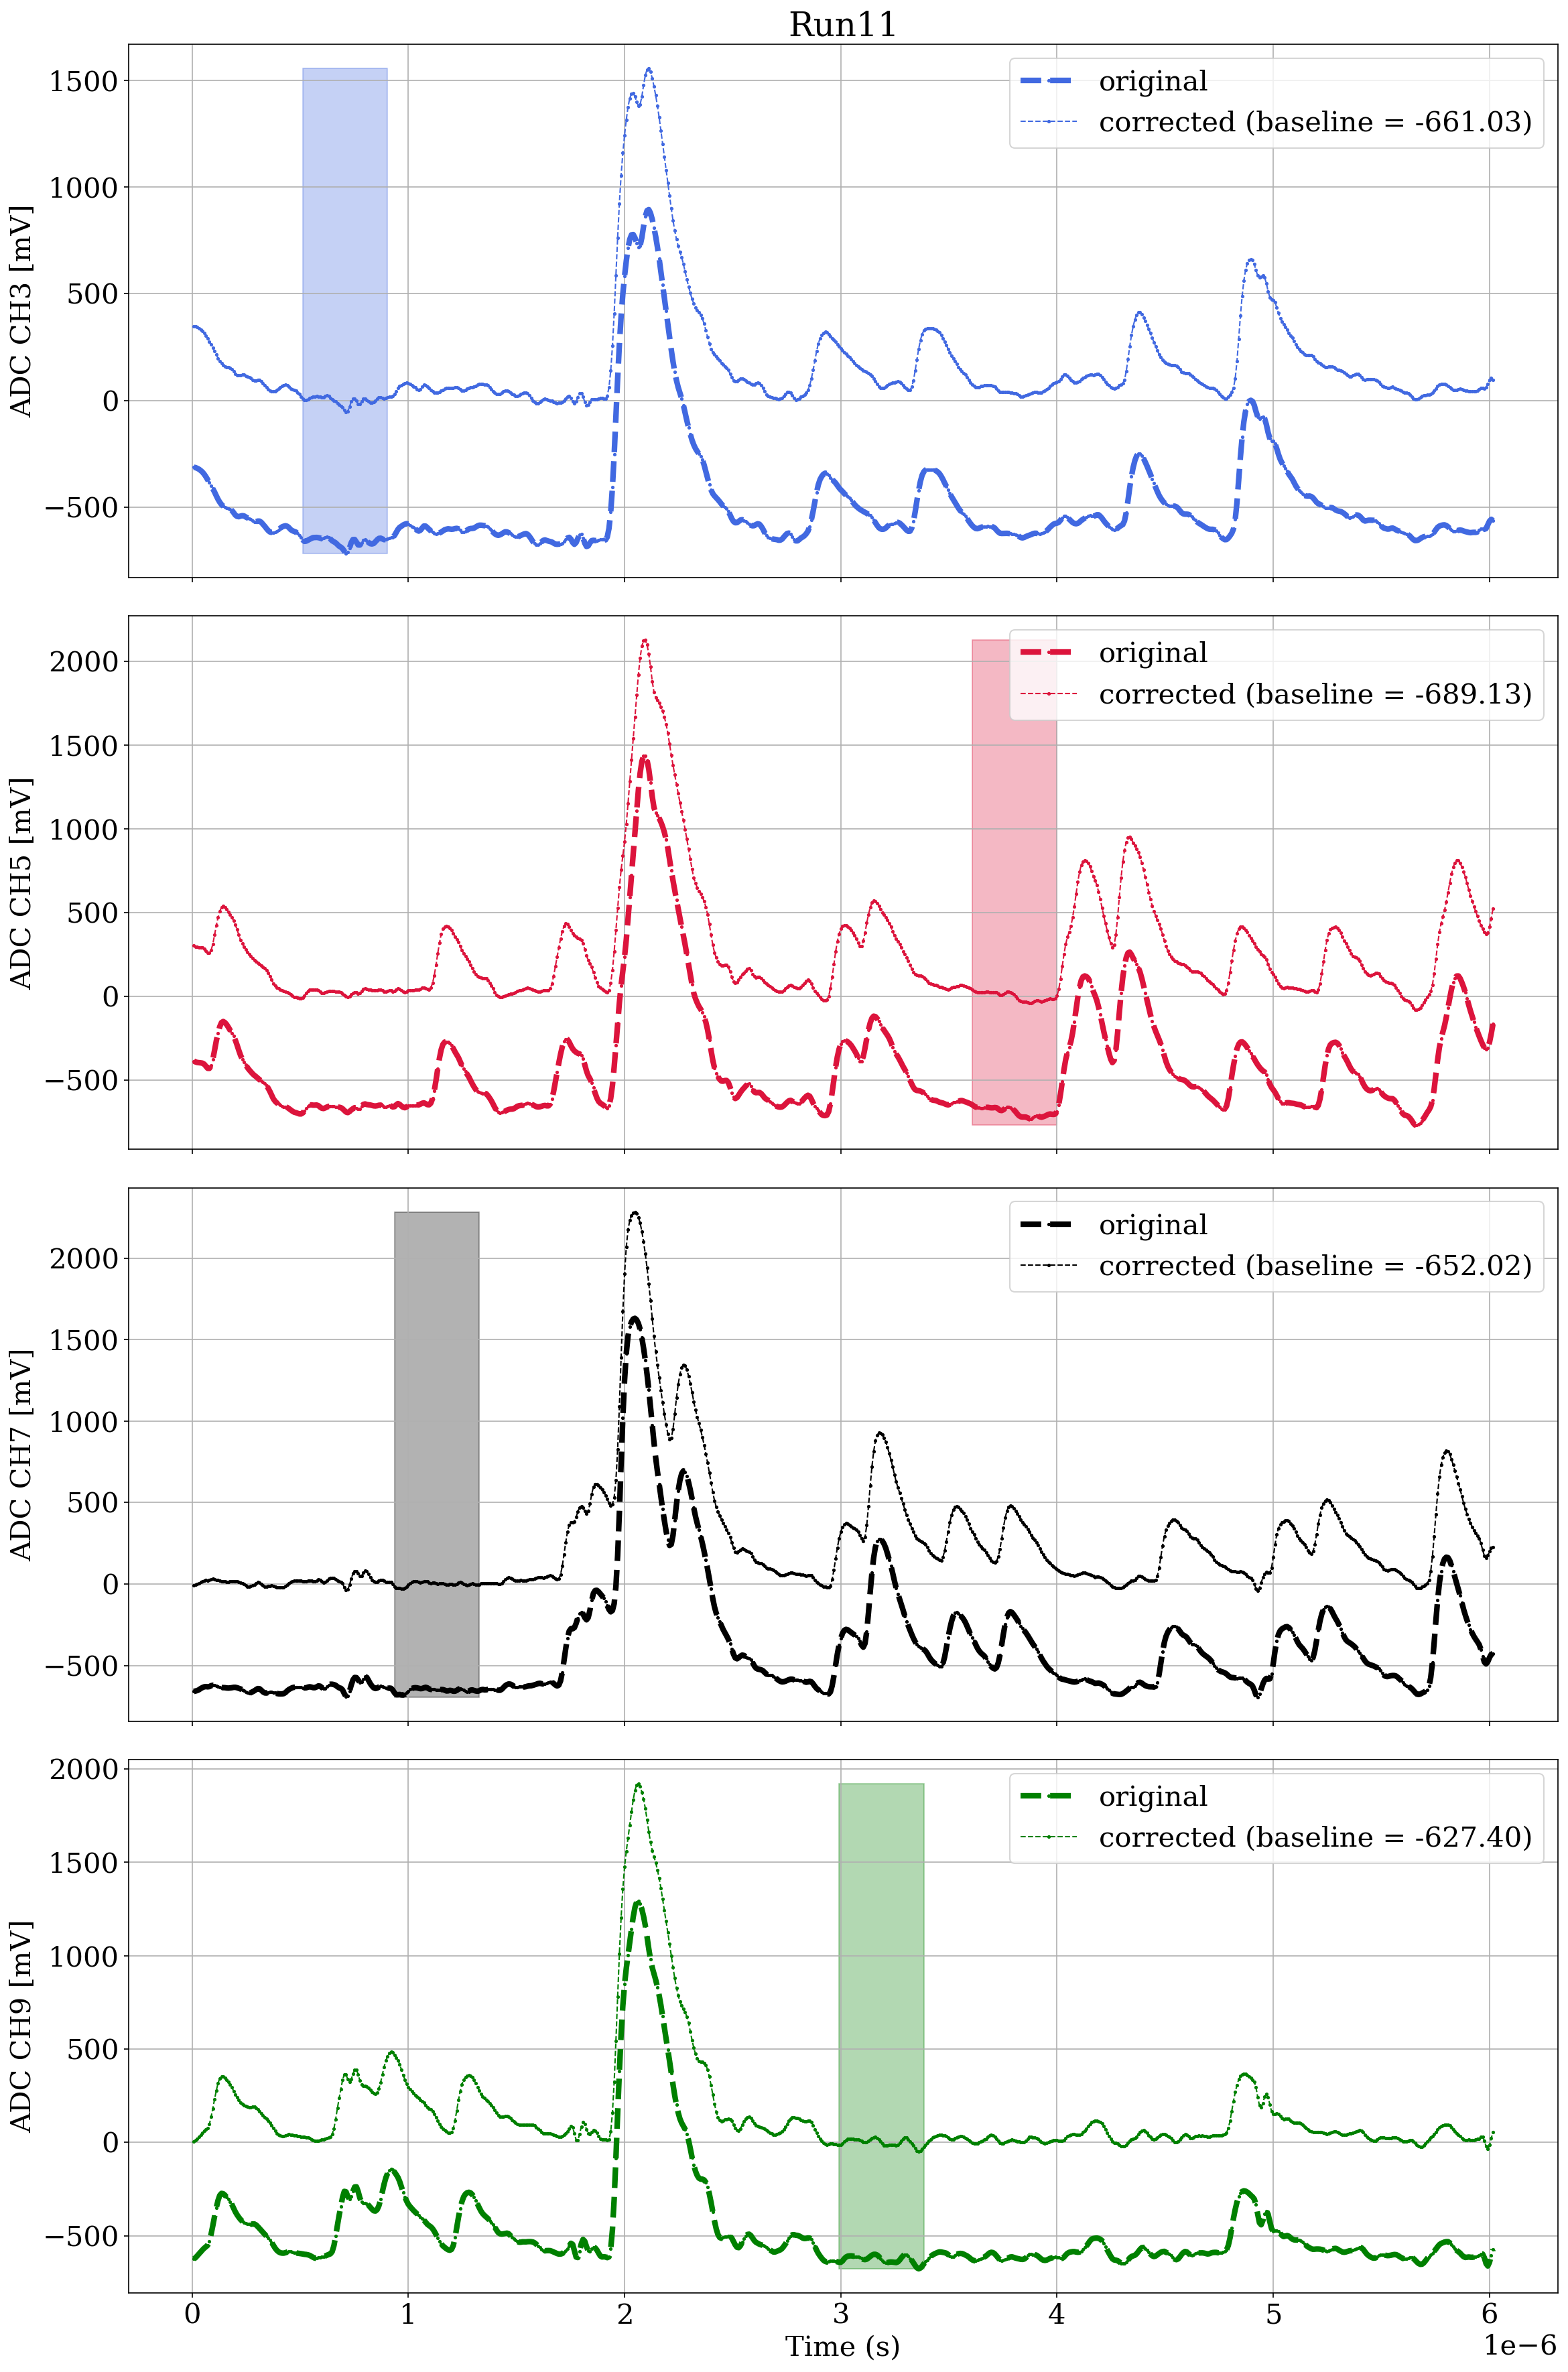

In [14]:
# Create subplots: 2 rows, 1 column

selected_ev = 20

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_ev], v_matrix[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=4, label=f'original')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected (baseline = {baselines[selected_ev]:.2f})')
    

    start = max(window[selected_ev], 0)
    end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    ax.fill_between(time[start:end], 
                    min(v_matrix_corrected[selected_ev].min(), v_matrix[selected_ev].min()), 
                    max(v_matrix_corrected[selected_ev].max(), v_matrix[selected_ev].max()), 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Charge spectrum

In [15]:
t_matrix = filtered_df['TIME'].values.reshape(nevents, -1)
time = t_matrix[0]

In [16]:
time_window = (1.8e-6 < time)  & (time < 3e-6)

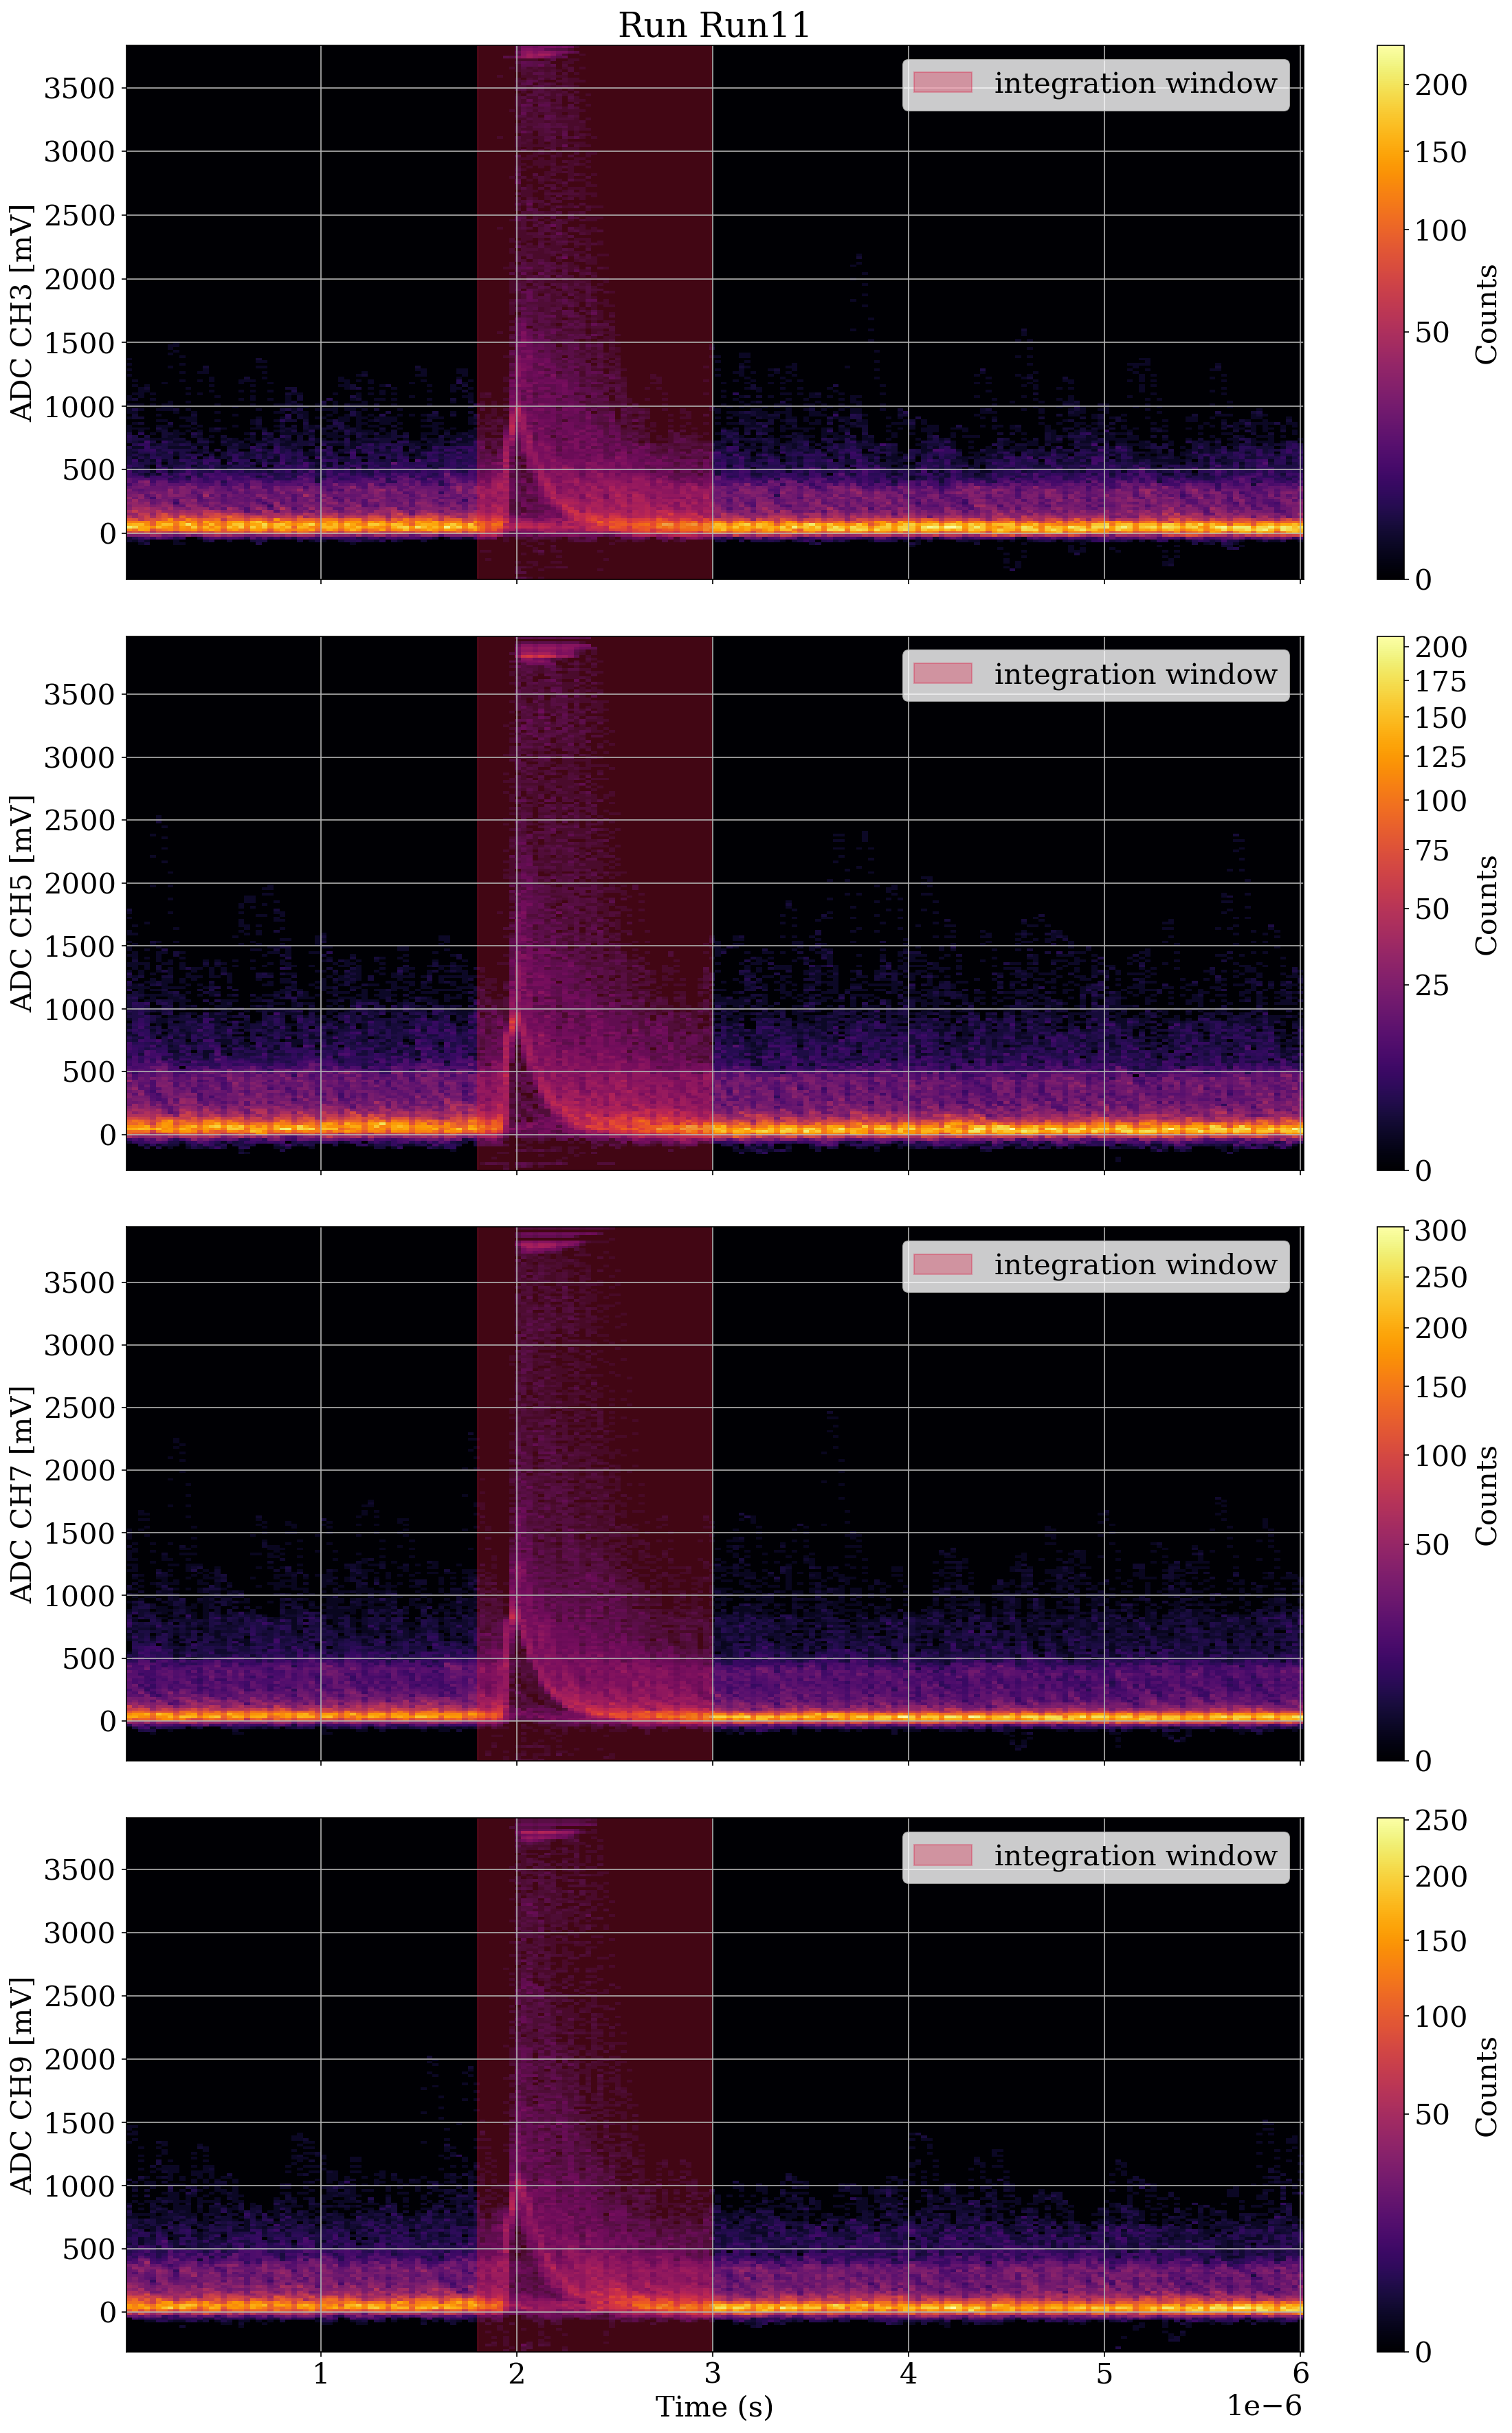

In [17]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'Run {run}')
else:
    ax.set_title(f'{run}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = filtered_df[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.5))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time[time_window], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

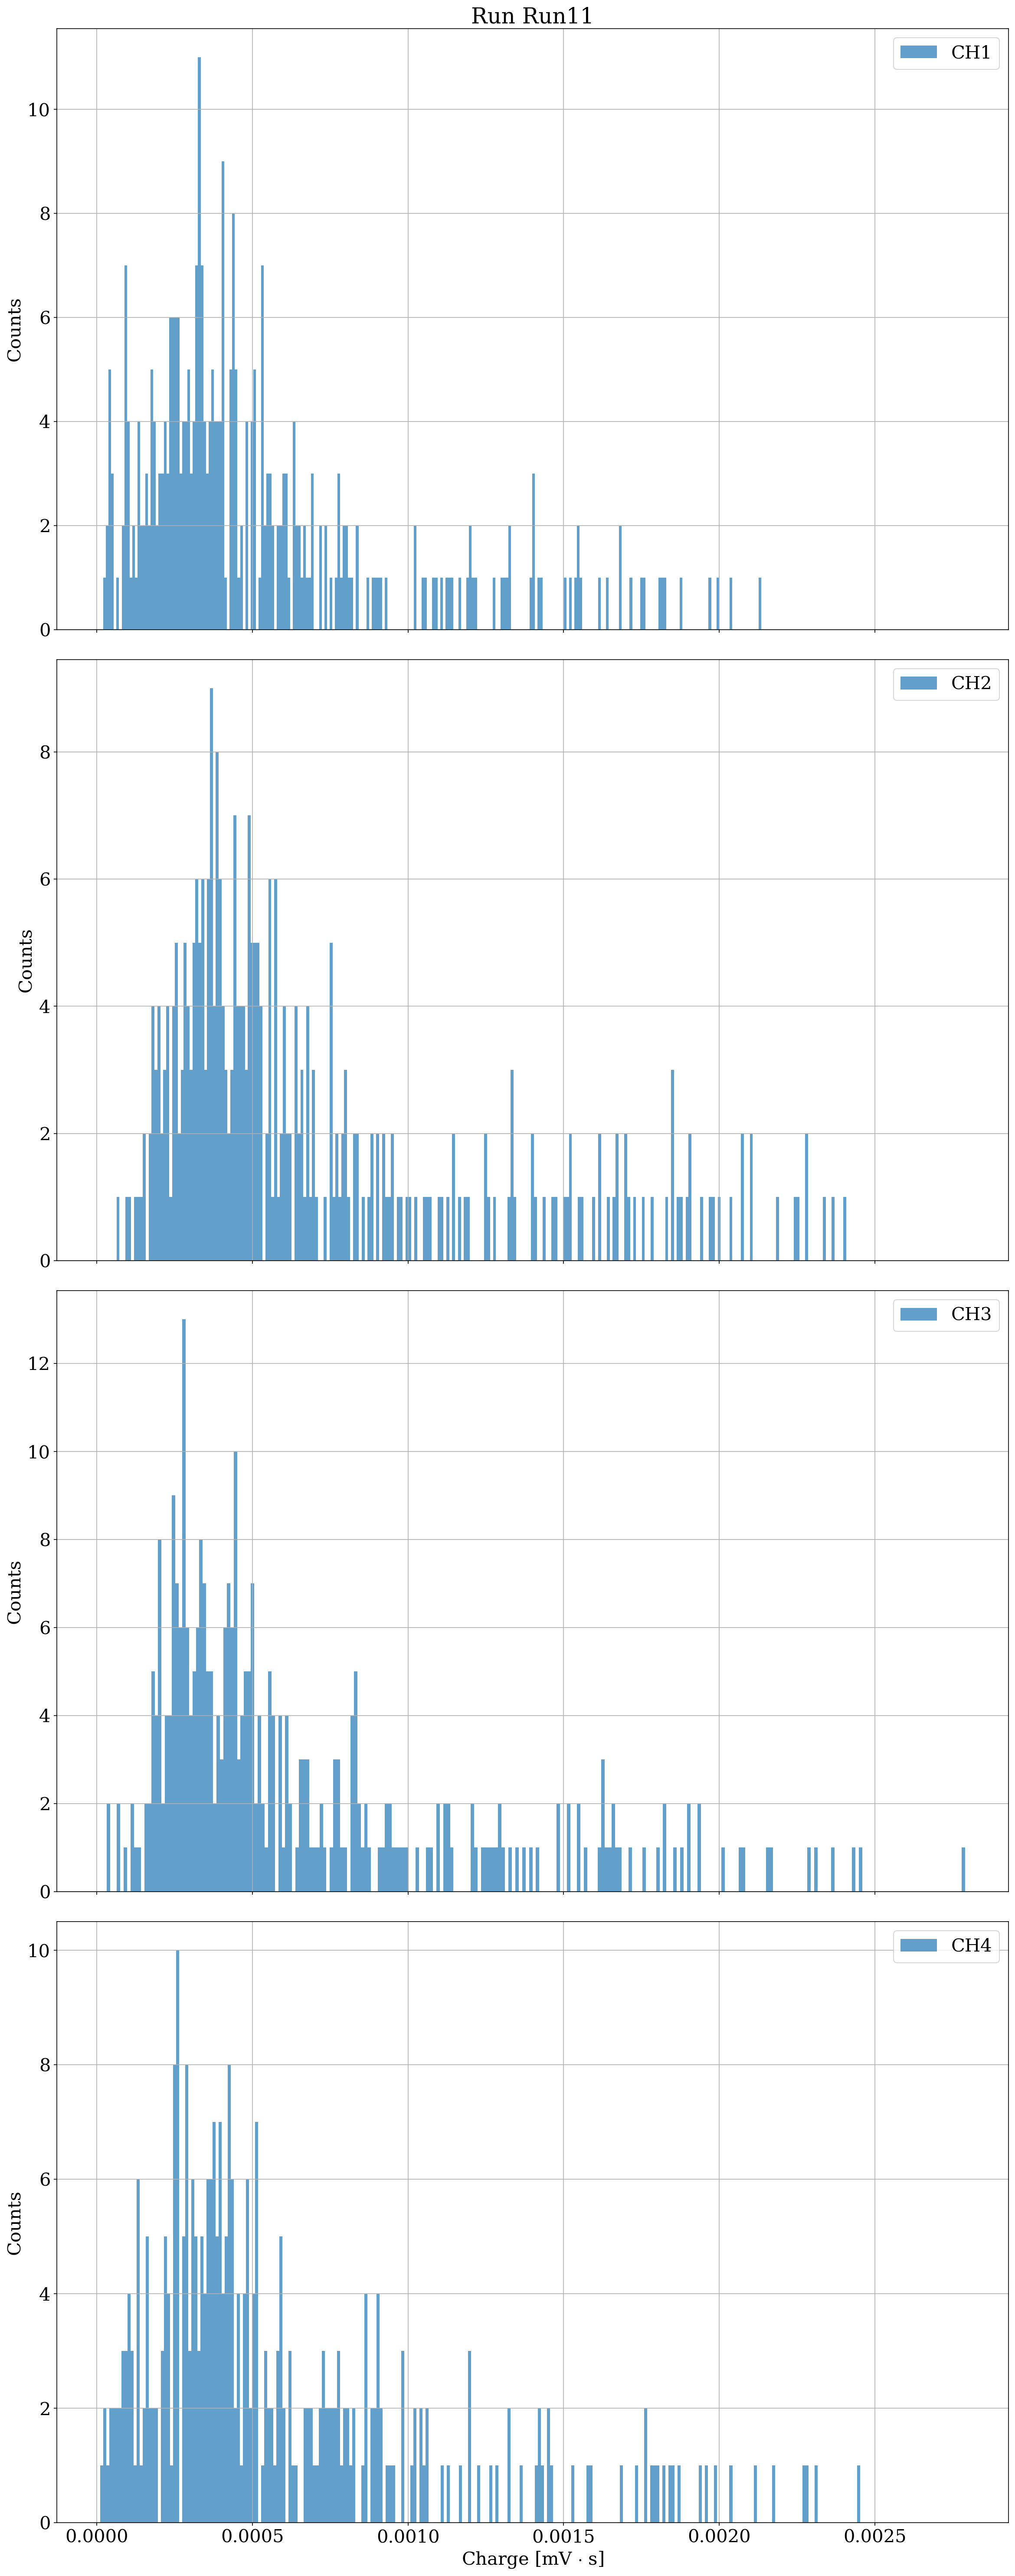

In [18]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*10), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, sharex=True)


if len(channels) > 1:
    axs[0].set_title(f'Run {run}')
else:
    ax.set_title(f'{run}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents, -1)
    v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)


    charge = np.trapz(v_matrix_corrected[:, time_window],
                      x = time[time_window]
                      ,axis = 1)

    events, bins, image = ax.hist(charge
                                ,bins = 250 
                                ,density = False
                                ,alpha = 0.7
                                ,label = f'CH{i+1}'
                                )
    
    ax.set_ylabel(f'Counts')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel(r'Charge [mV $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [mV $\cdot$ s]')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()